<a href="https://colab.research.google.com/github/jonathabsilva/TecImpIA/blob/main/Avaliacao1TAIA%5BAjustada%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação 1
Consideração o modelo de previsão de demanda, realizar a análise dos seguintes itens:

1. Modificar as funções de ativação utilizando Relu, Sigmod, tanh, etc. Analisar o desempenho da RNA. ✅

2. Modificar o número de camadas ocultas e neurônios (Sintonização da melhor rede) https://wandb.ai/site 

3. Realizar um estudo sobre o otimizador “Adam”

4. Na fase de teste, avaliar as métricas de:

  a. Erro Relativo Absoluto: |t-s|/t

  b. MAPE ✅

  c. Máximo Erro Relativo Absoluto: max(|t-s|)/t

5. Realizar a Previsão diária considerando um dia para frente e sete dias para atrás, com a finalidade de encontrar a melhor rede com ERA<10% e MAPE<3%. Utilize a 'Normalização' e faça a 'desnormalização' para mostrar os valores da previsão da potência. ✅

# Importação das Bibliotecas

Aqui, importa-se as seguintes bibliotecas:
1. tensorflow - 
2. pandas - 
3. numpy - 
4. matplotlib.pyplot - 



In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Biblioteca 

In [2]:
def Err_Rel_Abs(a,b):    
  from statistics import mean
  ERA = list()
  for i in range(len(a)):
    ERA.append(abs((a[i] - b[i])/a[i])[0])
  return ERA

In [3]:
def gera_camadas(n_min, n_max):
  camadas = list()
  for i in range(n_min,n_max):
    for j in range(n_min,n_max):
      camadas.append([i,j,1])
  return camadas

In [4]:
def str2list(string):
  string = string.split('[')[1]
  string = string.split(']')[0]
  string = string.split(', ')
  camada = list()
  for i in range(len(string)):
    camada.append(int(string[i]))

  return camada

# Leitura e Ajuste dos Dados

In [5]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/DESENVOLVIMENTO PESSOAL/MESTRADO/TÉCNICAS APLICADAS DE INTELIGÊNCIA ARTIFICIAL/Exemplo Previsão de Demanda/Parte 1 - Atualizado/dados_demanda.csv',delimiter=';')
df.dropna(axis=1,inplace=True)

df['TEMPO'] = df[['DIA','MES','ANO','HORA','MINUTO']].apply(lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3],minute=x[4]), axis=1)
df.drop(['MINUTO','HORA','ANO','DIA','MES'],axis=1,inplace=True)
df.rename(columns={'JPS_12B1':'POTENCIA'},inplace=True)
df['POTENCIA']=df['POTENCIA'].str.replace(',', '.').astype(float)
df.set_index('TEMPO',inplace=True)

In [7]:
maxima_semanal=df.resample('W').agg(['max'])

In [8]:
dias_tras = 7
dias_frente = 1

In [9]:
data = pd.DataFrame()
data['POTÊNCIA'] = maxima_semanal

for i in range(1,dias_tras+1):
  data['POTÊNCIA(K-'+str(i)+')'] = maxima_semanal.shift(i)

for i in range(1,dias_frente+1):
  data['POTÊNCIA(K+'+str(i)+')'] = maxima_semanal.shift(-i)

In [10]:
data.dropna(axis=0, inplace=True)
dataMax = data

In [11]:
np.array(maxima_semanal.agg(['max']))[0][0]

24.1000003814697

In [12]:
fator_treino = 0.72
data_dim, len_data = data.shape #Pega a quantidade de dados. O segundo termo não é necessário, pois já se sabe a quantidade de colunas de treinamento e de saída. 
data_treino_dim = data_dim*fator_treino

len_train = dias_tras+1 #Número de colunas usadas para treino

In [13]:
data = np.array(data)
data = tf.keras.utils.normalize(data,axis=1)

x_train = data[0:216,0:len_train]
y_train = data[0:216,len_train:len_data]

x_test = data[216:308,0:len_train]
y_test = data[216:308,len_train:len_data]

In [14]:
data.shape

(306, 9)

# Questão 01

Modificar as funções de ativação utilizando Relu, Sigmod, tanh, etc. Analisar o desempenho da RNA.

In [15]:
funcoes = [tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh, tf.nn.softmax]
medicoes = dict()
val_loss = dict()
val_mse = dict()

for funcao in funcoes:

  # Criando Rede
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(8))

  for i in [20,20,1]:
    model.add(tf.keras.layers.Dense(i,activation=funcao))

  # Parâmetros de treinamento
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics = ['mean_squared_error'])

  # Treinando 
  model.fit(x_train,y_train,epochs=500)
  val_loss[funcao], val_mse[funcao] = model.evaluate(x_test,y_test)

melhor_funcao = list(val_mse.keys()) [list(val_mse.values()).index(min(val_mse.values()))]
melhor_funcao

Epoch 1/500
7/7 [==============================] - 1s 3ms/step - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 2/500
7/7 [==============================] - 0s 3ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/500
7/7 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015    
Epoch 4/500
7/7 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 5/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 6/500
7/7 [==============================] - 0s 3ms/step - loss: 4.6100e-04 - mean_squared_error: 4.6100e-04
Epoch 7/500
7/7 [==============================] - 0s 3ms/step - loss: 6.5232e-04 - mean_squared_error: 6.5232e-04
Epoch 8/500
7/7 [==============================] - 0s 2ms/step - loss: 4.9931e-04 - mean_squared_error: 4.9931e-04
Epoch 9/500
7/7 [==============================] - 0s 3ms/step - loss: 4.0318e-04 - mean_squared_error: 4.0318e-04
E

<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>

In [16]:
melhor_funcao = list(val_mse.keys()) [list(val_mse.values()).index(min(val_mse.values()))]
melhor_funcao


<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>

In [17]:
val_loss

{<function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>: 0.0003182766668032855,
 <function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>: 0.0003970510442741215,
 <function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>: 0.0003008588682860136,
 <function tensorflow.python.ops.nn_ops.softmax_v2(logits, axis=None, name=None)>: 0.4476436972618103}

# Questão 02

Modificar o número de camadas ocultas e neurônios (Sintonização da melhor rede)

In [18]:
medicoes = dict()
val_loss = dict()
val_mse = dict()

camadas = gera_camadas(3,33)

for camada in camadas:

  # Criando Rede
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(dias_tras+dias_frente))

  for i in camada:
    model.add(tf.keras.layers.Dense(i,activation=melhor_funcao))

  # Parâmetros de treinamento
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics = ['mean_squared_error'])

  # Treinando 
  model.fit(x_train,y_train,epochs=10)
  val_loss[str(camada)], val_mse[str(camada)] = model.evaluate(x_test,y_test)

melhor_camada = list(val_mse.keys()) [list(val_mse.values()).index(min(val_mse.values()))]

Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 7.1676e-04 - mean_squared_error: 7.1676e-04
Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 5.7311e-04 - mean_squared_error: 5.7311e-04
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 5.9320e-04 - mean_squared_error: 5.9320e-04
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 5.7370e-04 - mean_squared_error: 5.7370e-04
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 5.6299e-04 - mean_squared_error: 5.6299e-04
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 5.3934e-04 - mean_squared_error: 5.3934e-04
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 5.3997e-04 - mean_squared_error: 5.3997e-04
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 5.5142e-04 - mean_squared_error: 5.5142e-04
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 5.2334e-04 - mean_

3/3 [==============================] - 0s 4ms/step - loss: 5.3411e-04 - mean_squared_error: 5.3411e-04
Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 8.2936e-04 - mean_squared_error: 8.2936e-04
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 3.3844e-04 - mean_squared_error: 3.3844e-04
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 5.1985e-04 - mean_squared_error: 5.1985e-04
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 5.1612e-04 - mean_squared_error: 5.1612e-04
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 3.9283e-04 - mean_squared_error: 3.9283e-04
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 3.0471e-04 - mean_squared_error: 3.0471e-04
E

A saída de streaming foi truncada nas últimas 5000 linhas.
3/3 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030    
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 6.9749e-04 - mean_squared_error: 6.9749e-04
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 7.0936e-04 - mean_squared_error: 7.0936e-04
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 4.2419e-04 - mean_squared_error: 4.2419e-04
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 3.7612e-04 - mean_squared_error: 3.7612e-04
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss

In [19]:
camada = str2list(melhor_camada)
camada 

[4, 18, 1]

# Questão 03
Realizar um estudo sobre o otimizador “Adam”

#Questão 4
 Na fase de teste, avaliar as métricas de:

  a. Erro Relativo Absoluto: |t-s|/t

  b. MAPE 

  c. Máximo Erro Relativo Absoluto: max(|t-s|)/t 

## a. Erro Relativo Absoluto

 |t-s|/t

In [21]:
y_pred = model.predict(x_test)
Err_Rel_Abs(y_test, y_pred)

[0.009593874069349048,
 0.03235981869506323,
 0.02511379143338925,
 0.002031272752284491,
 0.02397376119602904,
 0.04103372292167191,
 0.03923652750510218,
 0.049509307452841156,
 0.14263026848195404,
 0.09748233907172983,
 0.06391799644681753,
 0.06792530606351851,
 0.05560680972983963,
 0.11283796073522452,
 0.11704254859292569,
 0.093776391441474,
 0.007805162486925806,
 0.0125948578920251,
 0.016685427376443494,
 0.0024921320421055723,
 0.046918339548949486,
 0.032550074506087746,
 0.05923526790206242,
 0.02073124428225173,
 0.04342799166956043,
 0.050563702018460326,
 0.09598437413467154,
 0.06943928973467076,
 0.10466586707019741,
 0.05855343516262504,
 0.07340968405481231,
 0.06952886772134137,
 0.04460430103363365,
 0.0650211820254479,
 0.023805659814947373,
 0.08737010822148415,
 0.15178950212778994,
 0.07603545284060823,
 0.03779923769494633,
 0.06175603896407924,
 0.01006041460295015,
 0.017814090045578983,
 0.061662746724087295,
 0.07355753425160783,
 0.0803148224685207,
 0

  ## b. MAPE 

In [22]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
MAPE 


0.057014069394873315

## c. Máximo Erro Relativo Absoluto: max(|t-s|)/t 

In [23]:
max(Err_Rel_Abs(y_test, y_pred))

0.22659267469456257

# Questão 05
Realizar a Previsão diária considerando um dia para frente e sete dias para atrás, com a finalidade de encontrar a melhor rede com ERA<10% e MAPE<3%. Utilize a 'Normalização' e faça a 'desnormalização' para mostrar os valores da previsão da potência.


## Treinamento

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(dias_tras+dias_frente))
for i in camada:
  model.add(tf.keras.layers.Dense(i,activation=melhor_funcao))

# Parâmetros de treinamento
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics = ['mean_squared_error'])

# Treinando 
model.fit(x_train,y_train,epochs=5000)
loss, mse = model.evaluate(x_test,y_test)


A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 2502/5000
7/7 [==============================] - 0s 2ms/step - loss: 1.1955e-04 - mean_squared_error: 1.1955e-04
Epoch 2503/5000
7/7 [==============================] - 0s 3ms/step - loss: 1.1754e-04 - mean_squared_error: 1.1754e-04
Epoch 2504/5000
7/7 [==============================] - 0s 3ms/step - loss: 1.2506e-04 - mean_squared_error: 1.2506e-04
Epoch 2505/5000
7/7 [==============================] - 0s 3ms/step - loss: 1.2937e-04 - mean_squared_error: 1.2937e-04
Epoch 2506/5000
7/7 [==============================] - 0s 3ms/step - loss: 1.2296e-04 - mean_squared_error: 1.2296e-04
Epoch 2507/5000
7/7 [==============================] - 0s 3ms/step - loss: 1.2317e-04 - mean_squared_error: 1.2317e-04
Epoch 2508/5000
7/7 [==============================] - 0s 3ms/step - loss: 1.1808e-04 - mean_squared_error: 1.1808e-04
Epoch 2509/5000
7/7 [==============================] - 0s 3ms/step - loss: 1.1672e-04 - mean_squared_error: 

## Examinando o desempenho da rede

In [25]:
maximo = np.array(maxima_semanal.agg(['max']))[0][0]

3/3 [==============================] - 0s 3ms/step - loss: 6.6987e-06 - mean_squared_error: 6.6987e-06


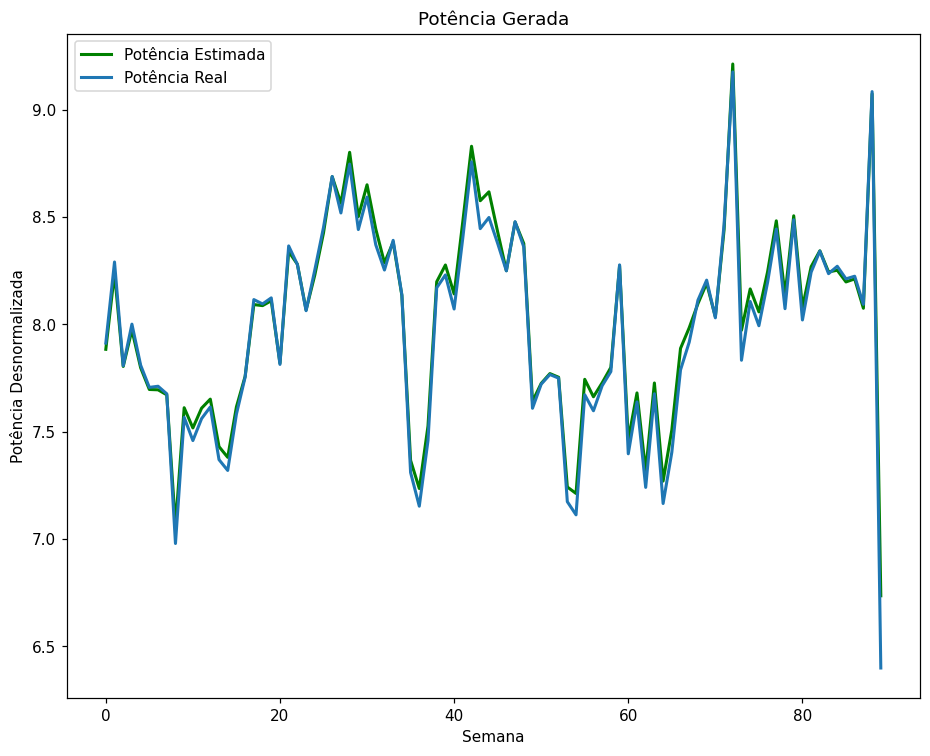

In [26]:
val_loss, val_mse = model.evaluate(x_test,y_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10,8),dpi=110)
plt.plot(y_pred[:,0]*maximo,lw=2,color='Green')
plt.plot(y_test[:,0]*maximo,lw=2)

plt.title('Potência Gerada')
plt.xlabel('Semana')
plt.ylabel('Potência Desnormalizada')
plt.legend(['Potência Estimada','Potência Real']) 

In [27]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
ERA = max(Err_Rel_Abs(y_test, y_pred))

print('MAPE: '+str(MAPE*100)+'%')
print('ERA: '+str(ERA*100)+'%')

if (MAPE*100 < 3) and (ERA*100 < 10):
  print('\nCondições atendidas!')
else:
  print('\nCondições não atendidas.')

MAPE: 0.5612167381974792%
ERA: 5.256187132056699%

Condições atendidas!
